In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import quandl
import quandl as q
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
quandl.ApiConfig.api_key = "-qMZRw2S5XascrrTLjF4"

In [2]:
#pega os dados da API
msft_data = q.get("EOD/MSFT", start_date="2010-01-01", end_date="2020-01-01")
msft_data.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2013-09-03,31.7500,32.07,31.29,31.880,154507000.0,0.0,1.0,27.484005,27.761009,27.085812,27.596538,154507000.0
2013-09-04,31.3900,31.47,31.11,31.195,142320600.0,0.0,1.0,27.172375,27.241626,26.929997,27.003576,142320600.0
2013-09-05,31.1000,31.44,30.95,31.235,71644900.0,0.0,1.0,26.921340,27.215657,26.791495,27.038201,71644900.0
2013-09-06,31.3100,31.39,31.13,31.152,75434900.0,0.0,1.0,27.103124,27.172375,26.947309,26.966354,75434900.0
2013-09-09,31.2208,31.79,31.20,31.655,49628500.0,0.0,1.0,27.025909,27.518631,27.007904,27.401769,49628500.0


In [3]:
# chama `Adj Close` para `daily_close`
daily_close = msft_data[['Adj_Close']]


Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2005.727, BIC=2015.638, Time=0.148 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2007.691, BIC=2022.558, Time=0.188 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=2009.580, BIC=2029.402, Time=0.282 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=2009.802, BIC=2034.580, Time=0.375 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=2011.304, BIC=2041.037, Time=0.523 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=2012.263, BIC=2046.952, Time=0.735 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2007.692, BIC=2022.558, Time=0.120 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2009.691, BIC=2029.514, Time=0.285 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=2006.595, BIC=2031.373, Time=1.995 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=2008.444, BIC=2038.177, Time=2.306 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=2010.438, BIC=2045.127, Time=2.

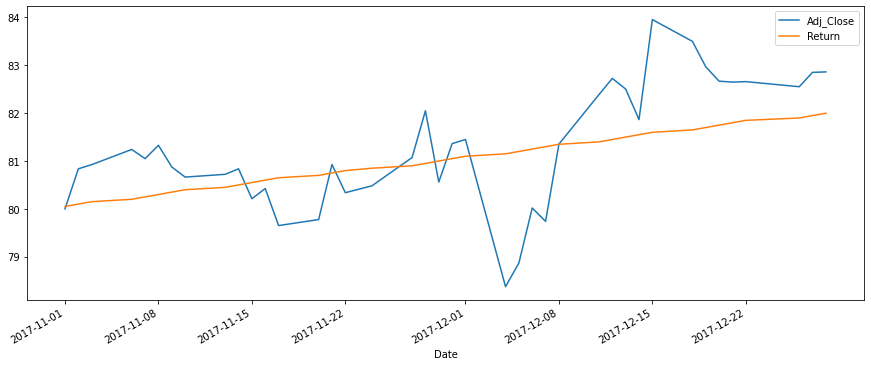

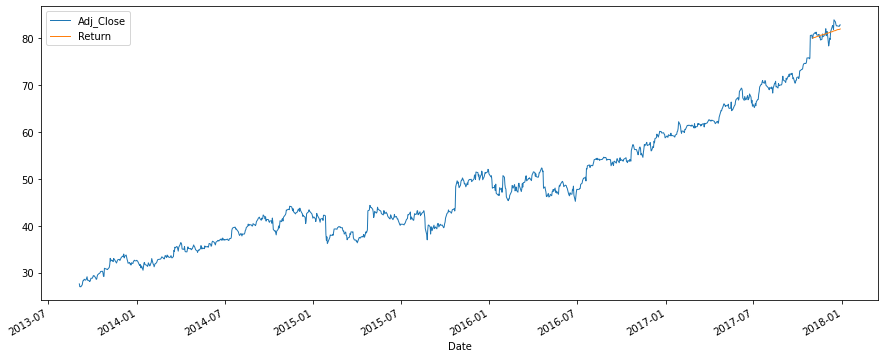

In [20]:
#train = daily_close.loc['2013-09-03':'2017-12-21']
#test = daily_close.loc['2017-12-22':]
k = 1050
train = daily_close[:k]
test = daily_close[k:]

step_model = auto_arima(train, start_p = 1, start_q = 1, max_p = 6, max_q = 6, m = 365, start_P = 0,
                       seasonal = False, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings = True,
                       stepwise = False)

#print(step_model.aic())

step_model.fit(train)

future_forecast = step_model.predict(n_periods = len(test))

future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Return'])

pd.concat([test,future_forecast],axis=1).plot()

pd.concat([daily_close,future_forecast],axis=1).plot(linewidth = 1)

In [19]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(future_forecast.values, test.values)

c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\users\binks\desktop\quantamental\quantenv\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


{'mape': 0.06658753934439382,
 'me': -5.305197592855763,
 'mae': 5.305197592855763,
 'mpe': -0.06658753934439382,
 'rmse': 6.452906609447656,
 'acf1': 0.958453875353491,
 'corr': nan,
 'minmax': 0.06658753934439376}

In [17]:
for k in range(30,50):
    train = daily_close[:k]
    test = daily_close[k:]

    step_model = auto_arima(train, start_p = 1, start_q = 1, max_p = 6, max_q = 6, m = 365, start_P = 0,
                           seasonal = False, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings  = True,
                           stepwise = False)
    
    step_model.fit(train)

    future_forecast = step_model.predict(n_periods = len(test))

    future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Return'])

    mape = np.mean(np.abs(future_forecast.values - test.values)/np.abs(test.values))  # MAPE
    lul = [step_model, mape, i]
    infos.append(lul)

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=21.083, BIC=23.817, Time=0.017 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=21.650, BIC=25.752, Time=0.071 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=23.093, BIC=28.562, Time=0.197 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=18.920, BIC=25.756, Time=0.514 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=20.594, BIC=28.798, Time=0.600 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=12.529, BIC=22.100, Time=0.882 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=21.495, BIC=25.597, Time=0.036 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=23.484, BIC=28.953, Time=0.177 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=21.566, BIC=28.402, Time=0.492 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=18.743, BIC=26.947, Time=0.677 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=21.492, BIC=31.063, Time=0.672 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [inte

NameError: name 'infos' is not defined

In [22]:
def getlinear_coefi(x,y):
    
    m = (len(x) * np.sum(x*y) - np.sum(x) * np.sum(y)) / (len(x)*np.sum(x*x) - np.sum(x) * np.sum(x))
    return m

compra = []
venda = []
n = 0
habilitador_compra = 1
habilitador_venda = 0
mk_1 = 0
mk_2 = 0
triple = []

for k in range(30,len(daily_close[:150])):
    train = daily_close[k-30:k-1]
    test = daily_close[k:k+15]

    step_model = auto_arima(train, start_p = 1, start_q = 1, max_p = 6, max_q = 6, m = 365, start_P = 0,
                       seasonal = False, d = 1, D = 1, trace = True, error_action = 'ignore', suppress_warnings = True,
                       stepwise = False)

    step_model.fit(train)

    future_forecast = step_model.predict(n_periods = len(test))

    future_forecast = pd.DataFrame(future_forecast, index=test.index, columns=['Return'])
    
    y = []
    x = []
    
    for el in future_forecast.values:
        x.append(float(el))
    for i in range(len(future_forecast.values)):
        y.append(i)

    m = getlinear_coefi(np.array(x),np.array(y))
    mk = m
    if (mk < -10) and (mk_1 < -10) and (mk_2 < -10) and (habilitador_venda == 1):
        print('vende:')
        print(k)
        venda.append(k)
        habilitador_venda = 0
        habilitador_compra = 1
        
    if (mk > 10) and (mk_1 > 10) and (mk_2 > 10) and (habilitador_compra == 1):
        print('compra:')
        print(k)
        compra.append(k)
        habilitador_venda = 1
        habilitador_compra = 0
    
    triple.append([mk,mk_1,mk_2])
    mk_2 = mk_1
    mk_1 = mk

    print(k)

Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=21.094, BIC=23.758, Time=0.380 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=21.788, BIC=25.785, Time=0.051 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=23.439, BIC=28.768, Time=0.079 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=19.618, BIC=26.279, Time=0.333 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=21.267, BIC=29.261, Time=0.315 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=13.525, BIC=22.850, Time=0.466 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=21.732, BIC=25.729, Time=0.022 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=23.700, BIC=29.029, Time=0.048 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=21.602, BIC=28.263, Time=0.208 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=19.469, BIC=27.462, Time=0.335 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=22.188, BIC=31.513, Time=0.339 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [inte

Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=17.435, BIC=24.096, Time=0.211 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=14.079, BIC=22.072, Time=0.313 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=15.215, BIC=24.541, Time=0.508 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=18.296, BIC=23.625, Time=0.042 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=15.992, BIC=22.653, Time=0.246 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=15.366, BIC=23.359, Time=0.272 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=14.369, BIC=23.695, Time=0.268 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=18.968, BIC=25.629, Time=0.060 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=16.826, BIC=24.819, Time=0.234 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=18.880, BIC=28.205, Time=0.262 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=20.591, BIC=28.584, Time=0.079 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [inte

Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=17.716, BIC=25.709, Time=0.311 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=19.468, BIC=28.793, Time=0.230 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=21.256, BIC=29.250, Time=0.071 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=19.737, BIC=29.063, Time=0.314 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=22.900, BIC=32.226, Time=0.119 seconds
Total fit time: 3.500 seconds
38
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=18.443, BIC=21.107, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=17.828, BIC=21.824, Time=0.030 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=19.320, BIC=24.649, Time=0.045 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=17.644, BIC=24.305, Time=0.289 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=15.444, BIC=23.437, Time=0.251 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=14.249, BIC=23.574, Time=0.280 seconds

Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=31.147, BIC=37.808, Time=0.235 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=31.227, BIC=39.220, Time=0.257 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=33.407, BIC=42.733, Time=0.350 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=36.307, BIC=40.304, Time=0.018 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=37.708, BIC=43.036, Time=0.061 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=34.484, BIC=41.145, Time=0.156 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=32.027, BIC=40.020, Time=0.236 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=34.015, BIC=43.340, Time=0.317 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=35.817, BIC=41.146, Time=0.032 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=29.953, BIC=36.614, Time=0.199 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=26.036, BIC=34.029, Time=0.249 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [inte

Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=32.378, BIC=39.039, Time=0.251 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=32.076, BIC=40.069, Time=0.229 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=33.890, BIC=43.215, Time=0.299 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=38.203, BIC=44.864, Time=0.047 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=34.202, BIC=42.195, Time=0.228 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=35.677, BIC=45.002, Time=0.276 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=38.546, BIC=46.539, Time=0.070 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=35.669, BIC=44.994, Time=0.282 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=39.573, BIC=48.899, Time=0.078 seconds
Total fit time: 3.704 seconds
47
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=42.231, BIC=44.896, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=42.706, BIC=46.703, Time=0.029 seconds

Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=46.427, BIC=51.756, Time=0.059 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=45.960, BIC=52.621, Time=0.210 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=47.318, BIC=55.312, Time=0.294 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=49.302, BIC=58.627, Time=0.305 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=46.840, BIC=50.837, Time=0.016 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=45.227, BIC=50.556, Time=0.164 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=45.814, BIC=52.475, Time=0.200 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=47.543, BIC=55.536, Time=0.262 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=49.398, BIC=58.723, Time=0.273 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=48.030, BIC=53.359, Time=0.033 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=45.318, BIC=51.979, Time=0.193 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [inte

Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=50.639, BIC=59.964, Time=0.275 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=49.541, BIC=54.870, Time=0.026 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=47.085, BIC=53.746, Time=0.191 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=48.989, BIC=56.982, Time=0.226 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=51.145, BIC=60.470, Time=0.265 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=50.561, BIC=57.222, Time=0.043 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=48.965, BIC=56.958, Time=0.205 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=50.901, BIC=60.226, Time=0.337 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=50.767, BIC=58.760, Time=0.056 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=52.767, BIC=62.093, Time=0.108 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=52.767, BIC=62.093, Time=0.078 seconds
Total fit time: 3.391 seconds
56

Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=51.689, BIC=61.015, Time=0.136 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=51.690, BIC=61.016, Time=0.076 seconds
Total fit time: 4.116 seconds
60
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=45.650, BIC=48.314, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=47.640, BIC=51.636, Time=0.120 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=47.736, BIC=53.065, Time=0.064 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=48.610, BIC=55.271, Time=0.250 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=48.936, BIC=56.929, Time=0.242 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=50.932, BIC=60.258, Time=0.364 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=47.643, BIC=51.640, Time=0.027 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=46.217, BIC=51.546, Time=0.315 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=47.468, BIC=54.129, Time=0.328 seconds

Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=46.495, BIC=51.824, Time=0.207 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=48.066, BIC=54.728, Time=0.274 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=49.861, BIC=57.855, Time=0.274 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=51.392, BIC=60.718, Time=0.328 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=48.077, BIC=53.406, Time=0.036 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=48.133, BIC=54.794, Time=0.228 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=49.731, BIC=57.724, Time=0.326 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=48.403, BIC=57.728, Time=0.360 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=49.514, BIC=56.175, Time=0.059 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=50.666, BIC=58.659, Time=0.187 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=49.311, BIC=58.636, Time=0.311 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [inte

Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=39.117, BIC=47.110, Time=0.233 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=36.573, BIC=45.899, Time=0.170 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=38.342, BIC=46.335, Time=0.080 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=40.039, BIC=49.365, Time=0.119 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=39.717, BIC=49.043, Time=0.101 seconds
Total fit time: 2.931 seconds
69
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=35.570, BIC=38.235, Time=0.020 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=37.033, BIC=41.030, Time=0.026 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=38.855, BIC=44.183, Time=0.050 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=39.225, BIC=45.886, Time=0.074 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=33.096, BIC=41.089, Time=0.288 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=35.091, BIC=44.416, Time=0.275 seconds

Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=39.774, BIC=47.767, Time=0.258 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=42.765, BIC=52.090, Time=0.281 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=42.236, BIC=46.233, Time=0.019 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=43.159, BIC=48.488, Time=0.167 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=45.797, BIC=52.458, Time=0.116 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=45.752, BIC=53.746, Time=0.293 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=41.662, BIC=50.987, Time=0.294 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=44.201, BIC=49.530, Time=0.044 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=45.716, BIC=52.377, Time=0.125 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=46.828, BIC=54.821, Time=0.232 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=48.792, BIC=58.117, Time=0.277 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [inte

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=34.214, BIC=42.207, Time=0.143 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=32.978, BIC=42.303, Time=0.286 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=32.186, BIC=38.847, Time=0.045 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=34.170, BIC=42.163, Time=0.097 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=30.160, BIC=39.485, Time=0.255 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=33.975, BIC=41.968, Time=0.053 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=35.871, BIC=45.196, Time=0.110 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=35.053, BIC=44.378, Time=0.082 seconds
Total fit time: 2.540 seconds
vende:
78
78
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=28.152, BIC=30.816, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=29.816, BIC=33.812, Time=0.031 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=31.773, BIC=37.102, Time=0.0

Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=29.741, BIC=35.070, Time=0.156 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=31.738, BIC=38.399, Time=0.071 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=30.789, BIC=38.782, Time=0.237 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=30.821, BIC=40.146, Time=0.291 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=28.042, BIC=32.039, Time=0.017 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=29.971, BIC=35.299, Time=0.065 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=31.740, BIC=38.401, Time=0.116 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=32.988, BIC=40.981, Time=0.262 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=33.019, BIC=42.344, Time=0.166 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=29.851, BIC=35.180, Time=0.029 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=31.781, BIC=38.442, Time=0.126 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [inte

Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=29.306, BIC=38.631, Time=0.281 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=26.084, BIC=31.413, Time=0.038 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=27.733, BIC=34.394, Time=0.075 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=27.457, BIC=35.450, Time=0.266 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=30.872, BIC=40.198, Time=0.267 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=27.117, BIC=33.778, Time=0.062 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=29.117, BIC=37.110, Time=0.089 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=29.448, BIC=38.773, Time=0.229 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=29.117, BIC=37.110, Time=0.067 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=27.188, BIC=36.513, Time=0.285 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=30.265, BIC=39.590, Time=0.079 seconds
Total fit time: 2.659 seconds
87

Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=28.835, BIC=38.160, Time=0.297 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=34.252, BIC=43.577, Time=0.096 seconds
Total fit time: 3.128 seconds
91
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=27.992, BIC=30.656, Time=0.015 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=28.506, BIC=32.503, Time=0.059 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=28.854, BIC=34.182, Time=0.047 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=30.184, BIC=36.845, Time=0.066 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=31.269, BIC=39.262, Time=0.114 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=32.687, BIC=42.013, Time=0.245 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=28.015, BIC=32.012, Time=0.020 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=29.893, BIC=35.222, Time=0.053 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=30.098, BIC=36.759, Time=0.098 seconds

Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=40.120, BIC=46.781, Time=0.100 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=38.926, BIC=46.919, Time=0.285 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=36.385, BIC=45.710, Time=0.330 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=38.778, BIC=44.106, Time=0.037 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=40.668, BIC=47.330, Time=0.087 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=38.632, BIC=46.626, Time=0.273 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=28.689, BIC=38.015, Time=0.314 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=39.553, BIC=46.214, Time=0.047 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=40.835, BIC=48.828, Time=0.091 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=39.263, BIC=48.588, Time=0.341 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=39.291, BIC=47.284, Time=0.098 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [inte

Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=40.613, BIC=49.939, Time=0.321 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=39.533, BIC=47.526, Time=0.068 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=36.574, BIC=45.899, Time=0.335 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=41.333, BIC=50.658, Time=0.080 seconds
Total fit time: 3.785 seconds
100
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=34.913, BIC=37.577, Time=0.023 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=36.187, BIC=40.183, Time=0.051 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=38.111, BIC=43.440, Time=0.080 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=39.999, BIC=46.660, Time=0.078 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=37.450, BIC=45.443, Time=0.277 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=39.124, BIC=48.449, Time=0.380 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=36.257, BIC=40.253, Time=0.039 second

Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=39.361, BIC=47.354, Time=0.253 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=39.705, BIC=49.031, Time=0.284 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=37.554, BIC=41.551, Time=0.022 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=37.105, BIC=42.434, Time=0.277 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=39.432, BIC=46.093, Time=0.124 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=41.370, BIC=49.363, Time=0.164 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=40.219, BIC=49.544, Time=0.283 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=38.995, BIC=44.323, Time=0.035 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=39.171, BIC=45.832, Time=0.138 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=39.961, BIC=47.954, Time=0.325 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=41.563, BIC=50.889, Time=0.279 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [inte

Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=46.696, BIC=53.357, Time=0.162 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=47.982, BIC=55.975, Time=0.209 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=49.629, BIC=58.955, Time=0.247 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=49.259, BIC=55.920, Time=0.039 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=48.568, BIC=56.562, Time=0.222 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=49.229, BIC=58.555, Time=0.336 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=48.443, BIC=56.437, Time=0.064 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=47.878, BIC=57.203, Time=0.130 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=49.889, BIC=59.214, Time=0.094 seconds
Total fit time: 2.882 seconds
109
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=44.932, BIC=47.597, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=44.972, BIC=48.969, Time=0.029 second

113
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=46.064, BIC=48.729, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=46.988, BIC=50.984, Time=0.026 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=45.815, BIC=51.144, Time=0.121 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=47.248, BIC=53.909, Time=0.219 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=46.405, BIC=54.398, Time=0.283 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=44.109, BIC=53.434, Time=0.379 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=47.155, BIC=51.151, Time=0.017 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=45.316, BIC=50.645, Time=0.203 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=47.156, BIC=53.817, Time=0.219 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=48.796, BIC=56.789, Time=0.333 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=47.107, BIC=56.433, Time=0.310 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [

Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=40.639, BIC=47.300, Time=0.209 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=41.505, BIC=49.498, Time=0.228 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=42.188, BIC=51.513, Time=0.263 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=44.579, BIC=49.907, Time=0.028 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=40.518, BIC=47.179, Time=0.159 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=42.656, BIC=50.649, Time=0.144 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=38.998, BIC=48.323, Time=0.297 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=44.572, BIC=51.233, Time=0.082 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=40.992, BIC=48.986, Time=0.223 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=41.625, BIC=50.951, Time=0.243 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=43.245, BIC=51.238, Time=0.073 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [inte

Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=35.761, BIC=43.754, Time=0.255 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=34.882, BIC=44.208, Time=0.288 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=35.366, BIC=43.359, Time=0.070 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=36.445, BIC=45.771, Time=0.110 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=36.154, BIC=45.480, Time=0.098 seconds
Total fit time: 3.774 seconds
122
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=31.231, BIC=33.896, Time=0.013 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=32.391, BIC=36.388, Time=0.028 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=34.349, BIC=39.678, Time=0.042 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=24.440, BIC=31.101, Time=0.313 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=25.415, BIC=33.408, Time=0.290 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=26.563, BIC=35.888, Time=0.304 second

Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=23.860, BIC=30.521, Time=0.208 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=25.332, BIC=33.325, Time=0.280 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=27.143, BIC=36.469, Time=0.314 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=33.056, BIC=37.053, Time=0.020 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=35.049, BIC=40.377, Time=0.055 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=32.201, BIC=38.862, Time=0.303 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=25.413, BIC=33.407, Time=0.321 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=26.424, BIC=35.749, Time=0.319 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=35.056, BIC=40.385, Time=0.040 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=32.190, BIC=38.851, Time=0.209 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=33.413, BIC=41.406, Time=0.246 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [inte

Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=30.594, BIC=38.587, Time=0.330 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=26.924, BIC=36.250, Time=0.330 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=29.907, BIC=36.568, Time=0.070 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=27.608, BIC=35.601, Time=0.304 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=29.569, BIC=38.895, Time=0.330 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=29.629, BIC=37.622, Time=0.117 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=31.274, BIC=40.600, Time=0.257 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=31.564, BIC=40.890, Time=0.162 seconds
Total fit time: 4.021 seconds
131
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=28.241, BIC=30.905, Time=0.029 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=28.588, BIC=32.585, Time=0.059 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=30.521, BIC=35.850, Time=0.085 second

Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9.701, BIC=13.698, Time=0.030 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=11.629, BIC=16.958, Time=0.149 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=16.386, BIC=23.047, Time=0.096 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=15.530, BIC=23.523, Time=0.097 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=18.460, BIC=27.786, Time=0.273 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=9.888, BIC=13.885, Time=0.021 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=11.617, BIC=16.945, Time=0.079 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=13.295, BIC=19.956, Time=0.192 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=15.317, BIC=23.310, Time=0.238 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=17.426, BIC=26.752, Time=0.234 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=11.731, BIC=17.060, Time=0.040 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [interc

Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=31.391, BIC=38.052, Time=0.118 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=33.347, BIC=41.340, Time=0.185 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=33.609, BIC=42.934, Time=0.336 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=30.098, BIC=35.427, Time=0.032 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=31.381, BIC=38.042, Time=0.100 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=31.485, BIC=39.478, Time=0.270 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=33.452, BIC=42.777, Time=0.295 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=31.524, BIC=38.185, Time=0.051 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=33.509, BIC=41.502, Time=0.135 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=34.254, BIC=43.580, Time=0.256 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=33.486, BIC=41.479, Time=0.074 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [inte

Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=34.156, BIC=42.150, Time=0.239 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=37.604, BIC=46.929, Time=0.244 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=37.775, BIC=45.768, Time=0.072 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=35.999, BIC=45.324, Time=0.309 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=39.731, BIC=49.056, Time=0.079 seconds
Total fit time: 3.163 seconds
144
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=35.441, BIC=38.105, Time=0.011 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=36.199, BIC=40.195, Time=0.088 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=38.170, BIC=43.499, Time=0.044 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=37.959, BIC=44.620, Time=0.091 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=38.647, BIC=46.641, Time=0.263 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=39.637, BIC=48.962, Time=0.274 second

Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=39.209, BIC=45.870, Time=0.213 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=38.626, BIC=46.620, Time=0.255 seconds
Fit ARIMA(0,1,5)x(0,0,0,0) [intercept=True]; AIC=39.782, BIC=49.108, Time=0.289 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=39.108, BIC=43.105, Time=0.025 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=39.359, BIC=44.688, Time=0.157 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=41.327, BIC=47.989, Time=0.188 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=40.135, BIC=48.128, Time=0.247 seconds
Fit ARIMA(1,1,4)x(0,0,0,0) [intercept=True]; AIC=40.154, BIC=49.479, Time=0.302 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=41.075, BIC=46.404, Time=0.029 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=41.334, BIC=47.995, Time=0.204 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=40.510, BIC=48.504, Time=0.229 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [inte

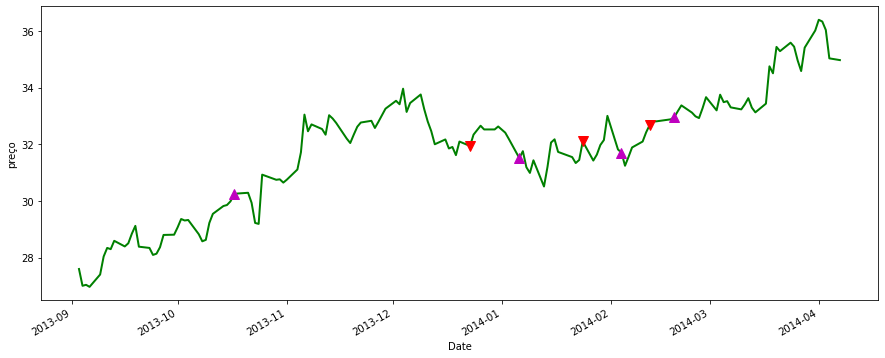

In [23]:
fig = plt.figure()

plt1 = fig.add_subplot(111,  ylabel='preço')

msft_data['Adj_Close'][:150].plot(ax=plt1, color='g', lw=2.)

# venda
#plt1.plot(msft_data['Adj_Close'][venda], 'v', markersize=10, color='r')

# compra
plt1.plot(msft_data['Adj_Close'][compra], '^', markersize=10, color='m')
         
# show
plt.show()

In [9]:
preco_venda = []
preco_compra = []
venda_total = 0
compra_total = 0
for el in venda:
    preco_venda.append(msft_data['Adj_Close'][el])
    venda_total = venda_total + msft_data['Adj_Close'][el]
for el in compra:
    preco_compra.append(msft_data['Adj_Close'][el])
    compra_total = compra_total + msft_data['Adj_Close'][el]

In [10]:
compra_total

28.79977471999124

In [11]:
venda_total/compra_total

0.0

In [12]:
triple

[[18.805955789973222, 0, 0],
 [30.136423095323952, 18.805955789973222, 0],
 [29.57356683014593, 30.136423095323952, 18.805955789973222],
 [22.065967541806337, 29.57356683014593, 30.136423095323952],
 [14.95973678126496, 22.065967541806337, 29.57356683014593],
 [15.678029546303941, 14.95973678126496, 22.065967541806337],
 [13.590792823387853, 15.678029546303941, 14.95973678126496],
 [11.892110068981918, 13.590792823387853, 15.678029546303941],
 [15.447559895230494, 11.892110068981918, 13.590792823387853],
 [14.547623870015762, 15.447559895230494, 11.892110068981918],
 [11.599964198765056, 14.547623870015762, 15.447559895230494],
 [12.761356684280159, 11.599964198765056, 14.547623870015762],
 [16.652118264491953, 12.761356684280159, 11.599964198765056],
 [18.230309552933935, 16.652118264491953, 12.761356684280159],
 [18.355512461817867, 18.230309552933935, 16.652118264491953],
 [17.01564717071866, 18.355512461817867, 18.230309552933935],
 [17.84260034327124, 17.01564717071866, 18.3555124

In [13]:
compra

[18]

In [14]:
venda

[]